In [ ]:
!pip install torchtext==0.11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 14.5 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x3934e000 @  0x7f43a2bc7615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 1.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 24 09:06:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchtext
torch.__version__, torchtext.__version__

('1.10.2+cu102', '0.11.2')

In [ ]:
import pandas as pd
from collections import Counter
import nltk
nltk.download('punkt')
import time
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torchtext.legacy import data

from google.colab import drive 
drive.mount('/content/gdrive')
PATH = "gdrive/My Drive/project_data/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/gdrive


In [ ]:
from torchtext.vocab import vocab
from torch.utils.data import DataLoader
from itertools import combinations
from torchtext.vocab import GloVe

In [ ]:
glove = GloVe(name='6B')

.vector_cache/glove.6B.zip: 862MB [02:42, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [00:35<00:00, 11155.76it/s]


In [ ]:
SEED = 1515

#random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1515)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
df = pd.read_csv(PATH+'train.csv')

In [ ]:
df['toxic'] = np.where(df['target'] > 0.5, 1, 0)
data = df[['comment_text','toxic']]

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size=0.2)

In [ ]:
def custom_tokenize(text):
    if not text:
        return ''
    return nltk.word_tokenize(text.lower())

In [ ]:
train = list(train.to_records(index=False))
val = list(val.to_records(index=False))

In [ ]:
def collate_into_cbow(batch):    
    label_vec = []
    cbow_vec = []
    for idx, (txt, l) in enumerate(batch):
        label_vec.append(l)
        tokenized = custom_tokenize(txt)
        vecs = glove.get_vecs_by_tokens(tokenized)
        c_vecs = torch.div(vecs.sum(dim=0), vecs.size()[0])
        c_vecs = c_vecs.unsqueeze(0)
        if idx == 0:
            cbow_vec = c_vecs
        else:
            cbow_vec = torch.cat([cbow_vec, c_vecs])

    labels = torch.tensor(label_vec)    
    return cbow_vec.to(device), labels.to(device)

In [ ]:
train_cbow = DataLoader(train, batch_size=64, shuffle=False, 
                        collate_fn=collate_into_cbow)

val_cbow = DataLoader(train, batch_size=64, shuffle=False, 
                        collate_fn=collate_into_cbow)

for idx, (lt, tt) in enumerate(train_cbow):
    print(idx, lt.shape, tt.shape)
    if idx == 2: break

0 torch.Size([64, 300]) torch.Size([64])
1 torch.Size([64, 300]) torch.Size([64])
2 torch.Size([64, 300]) torch.Size([64])


In [ ]:
from torch import nn
import torch.nn.functional as F

# task 6
class cBoWClassifier(nn.Module):
    
    def __init__(self, num_labels, vocab_size):
        super(cBoWClassifier, self).__init__()
        self.nonlinearity = nn.Tanh()
        self.linear = nn.Linear(vocab_size, 200)
        self.hidden_1 = nn.Linear(200, 100)
        self.hidden_2 = nn.Linear(100, 50)
        self.hidden_3 = nn.Linear(50, num_labels)
        

    def forward(self, bow_vec):
        out = self.nonlinearity(self.linear(bow_vec))
        out = self.nonlinearity(self.hidden_1(out))
        out = self.nonlinearity(self.hidden_2(out))
        return F.log_softmax(self.hidden_3(out), dim=1)  

In [ ]:
BATCH_SIZE = 64
num_labels = 2
vocab_size = 300
model = cBoWClassifier(num_labels, vocab_size).to(device)

In [ ]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():
        correct_pred = 0
        total_samples = 0
        for idx, (text, label) in enumerate(dataloader):
            total_samples += text.size()[0]
            log_probs = model(text)
            predictions = torch.argmax(log_probs, dim=1)
            correct_pred += torch.eq(predictions, label).long().sum().item()
    return correct_pred/total_samples

In [ ]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader):
    model.train() # Sets the module in training mode.
    log_interval = 5000

    for idx, (text, label) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

At iteration 5000 the loss is 5.923.
At iteration 10000 the loss is 8.361.
At iteration 15000 the loss is 7.290.
At iteration 20000 the loss is 13.343.

After epoch 1 the validation accuracy is 0.941.

At iteration 5000 the loss is 10.327.
At iteration 10000 the loss is 0.672.
At iteration 15000 the loss is 11.680.
At iteration 20000 the loss is 9.770.

After epoch 2 the validation accuracy is 0.941.

At iteration 5000 the loss is 8.238.
At iteration 10000 the loss is 4.496.
At iteration 15000 the loss is 11.784.
At iteration 20000 the loss is 13.113.

After epoch 3 the validation accuracy is 0.941.

At iteration 5000 the loss is 5.042.
At iteration 10000 the loss is 4.695.
At iteration 15000 the loss is 2.810.
At iteration 20000 the loss is 11.254.

After epoch 4 the validation accuracy is 0.941.

At iteration 5000 the loss is 5.046.
At iteration 10000 the loss is 3.970.
At iteration 15000 the loss is 3.227.
At iteration 20000 the loss is 1.718.

After epoch 5 the validation accuracy 

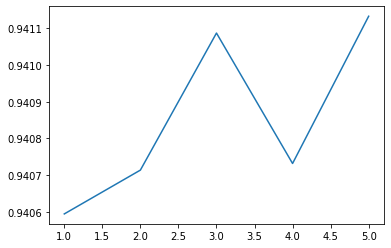

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 5 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_cbow)
    accuracy = get_accuracy(val_cbow)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)